<a href="https://colab.research.google.com/github/Michael-Sylvester/Ashesi-Deep-Learning/blob/main/Prosit_1(Image_Tagging).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount the google drive
import torch
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive
Using device: cpu
PyTorch version: 2.8.0+cu126


In [ ]:
# Set the device to GPU if it is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cpu
PyTorch version: 2.8.0+cu126


In [ ]:
# --- 1. Install and Import Necessary Packages ---
!pip install -q torchsummary
!pip install -q tqdm
from tqdm import tqdm

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets, models
from torchsummary import summary

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image

In [ ]:
# set the path to the directory where the dataset is kept. Use as constant
DATA_DIR = '/content/drive/MyDrive/Ashesi School Work/cinic-10'

print("Using Dataset from the drive short cut. Path: " + DATA_DIR)
# os.chdir(dataDir)
all_sub_dirs = os.listdir(DATA_DIR)
print("Contents of dataset directory:", all_sub_dirs)

# Set the variable that points to the root of the split training sub directories
dataDir = DATA_DIR

# Look for 'train', 'valid', 'test' subdirectories in the shortcut directory
if all(os.path.exists(os.path.join(dataDir, splitSet)) for splitSet in ['train', 'valid', 'test']):
     print(f"Found dataset sub directories in the shortcut directory.")
else:
    # If not directly there, look for a subfolder containing the split dataset sub directories
    found_subfolder = False
    for item in all_sub_dirs:
        item_path = os.path.join(dataDir, item)
        if os.path.isdir(item_path) and all(os.path.exists(os.path.join(item_path, subDir)) for subDir in ['train', 'valid', 'test']):
            dataDir = item_path
            print(f"Found dataset in subfolder: {item}")
            found_subfolder = True
            break
    if not found_subfolder:
        print("Warning: Could not find 'train', 'valid', 'test' subdirectories in the specified path or any immediate subfolder.")
        print("Make sure the shortcut points to the correct location of CINIC-10 dataset.")


train_dir = os.path.join(dataDir, 'train')
valid_dir = os.path.join(dataDir, 'valid')
test_dir = os.path.join(dataDir, 'test')

print(f"\nFinal paths:")
print(f"Train: {train_dir} - Exists: {os.path.exists(train_dir)}")
print(f"Valid: {valid_dir} - Exists: {os.path.exists(valid_dir)}")
print(f"Test: {test_dir} - Exists: {os.path.exists(test_dir)}")

Using Dataset from the drive short cut. Path: /content/drive/MyDrive/Ashesi School Work/cinic-10
Contents of dataset directory: ['valid', 'train', 'test']
Found dataset sub directories in the shortcut directory.

Final paths:
Train: /content/drive/MyDrive/Ashesi School Work/cinic-10/train - Exists: True
Valid: /content/drive/MyDrive/Ashesi School Work/cinic-10/valid - Exists: True
Test: /content/drive/MyDrive/Ashesi School Work/cinic-10/test - Exists: True


In [ ]:
# --- 4a. Subset Data from Original Splits with Custom Proportions ---

original_data_subset_percentage = 15 # param {type:"number"}

if original_data_subset_percentage < 0 or original_data_subset_percentage > 100:
    print("Warning: Total data percentage should be between 0 and 100. Using 100%.")
    original_data_subset_percentage = 100

# Define the NEW split percentages for the SELECTED SUBSET
# These percentages will determine the proportion of images taken from the *original* splits
# to form the new train, valid, and test sets.
train_split_percentage_subset = 70 # param {type:"number"}
valid_split_percentage_subset = 20 # param {type:"number"}
test_split_percentage_subset = 10 # param {type:"number"}

# Validate individual percentages
if not (0 <= train_split_percentage_subset <= 100 and
        0 <= valid_split_percentage_subset <= 100 and
        0 <= test_split_percentage_subset <= 100):
    print("Warning: One or more of the new subset split percentages are outside the 0-100 range. Please adjust them.")


# Check if the new subset percentages sum to 100
if train_split_percentage_subset + valid_split_percentage_subset + test_split_percentage_subset != 100:
    print("Warning: The new subset split percentages do not sum to 100. Adjusting test percentage for subset.")
    test_split_percentage_subset = 100 - train_split_percentage_subset - valid_split_percentage_subset
    print(f"Adjusted subset splits: Train: {train_split_percentage_subset}%, Valid: {valid_split_percentage_subset}%, Test: {test_split_percentage_subset}%")


# Get class names
# Assuming classes are the subdirectory names in the original train directory
class_names = sorted([dir.name for dir in os.scandir(train_dir) if dir.is_dir()])
num_classes = len(class_names)
print(f"\nClass names: {class_names}")
print(f"Number of classes: {num_classes}")

# Function to get a subset of image paths from a single directory while maintaining class distribution
# For each file it apends its nmae to the directory name to get it's path, shuffles the files and grabs "percentage_of_dir" of it
def get_subset_paths_from_dir(data_dir, classes, percentage_of_dir):
    image_paths_from_dir = []
    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        if os.path.exists(class_dir):
            image_files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
            num_samples_in_class = len(image_files)
            subset_size_class = int(num_samples_in_class * (percentage_of_dir / 100))
            np.random.shuffle(image_files)
            image_paths_from_dir.extend(image_files[:subset_size_class])
    return image_paths_from_dir

# Calculate the total number of images in the original dataset
total_original_images = sum(len(os.listdir(os.path.join(train_dir, c))) for c in class_names if os.path.exists(os.path.join(train_dir, c))) + \
                          sum(len(os.listdir(os.path.join(valid_dir, c))) for c in class_names if os.path.exists(os.path.join(valid_dir, c))) + \
                          sum(len(os.listdir(os.path.join(test_dir, c))) for c in class_names if os.path.exists(os.path.join(test_dir, c)))

# Calculate the target total subset size
target_subset_size = int(total_original_images * (original_data_subset_percentage / 100))

# Distribute the target subset size according to the desired new split percentages
target_train_size = int(target_subset_size * (train_split_percentage_subset / 100))
target_valid_size = int(target_subset_size * (valid_split_percentage_subset / 100))
target_test_size = target_subset_size - target_train_size - target_valid_size # Ensure sum is exactly 100

print(f"\nTarget total subset size: {target_subset_size}")
print(f"Target new split sizes: Train: {target_train_size}, Valid: {target_valid_size}, Test: {target_test_size}")


# To get the desired number of images for the new splits from their ORIGINAL directories,
# we need to calculate what percentage of the ORIGINAL split size corresponds to the TARGET new split size.

# Get the total number of images in the original splits
original_train_size = sum(len(os.listdir(os.path.join(train_dir, c))) for c in class_names if os.path.exists(os.path.join(train_dir, c)))
original_valid_size = sum(len(os.listdir(os.path.join(valid_dir, c))) for c in class_names if os.path.exists(os.path.join(valid_dir, c)))
original_test_size = sum(len(os.listdir(os.path.join(test_dir, c))) for c in class_names if os.path.exists(os.path.join(test_dir, c)))

# Calculate the percentage needed from each ORIGINAL split to meet the TARGET new split size
# Handle division by zero if original split is empty
percentage_from_original_train = (target_train_size / original_train_size) * 100 if original_train_size > 0 else 0
percentage_from_original_valid = (target_valid_size / original_valid_size) * 100 if original_valid_size > 0 else 0
percentage_from_original_test = (target_test_size / original_test_size) * 100 if original_test_size > 0 else 0

print(f"\nPercentage to sample from original splits:")
print(f"From Original Train: {percentage_from_original_train:.2f}%")
print(f"From Original Valid: {percentage_from_original_valid:.2f}%")
print(f"From Original Test: {percentage_from_original_test:.2f}%")


# Get subset of image paths from original directories using the calculated percentages
# Use tqdm for progress bars
new_train_paths = get_subset_paths_from_dir(train_dir, class_names, percentage_from_original_train)
new_valid_paths = get_subset_paths_from_dir(valid_dir, class_names, percentage_from_original_valid)
new_test_paths = get_subset_paths_from_dir(test_dir, class_names, percentage_from_original_test)

print(f"\nActual new split sizes after sampling:")
print(f"Train: {len(new_train_paths)}")
print(f"Valid: {len(new_valid_paths)}")
print(f"Test: {len(new_test_paths)}")


# Custom Dataset class to load from a list of file paths (same as before)
class ListDataset(Dataset):
    def __init__(self, image_paths, class_names, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        # Create a mapping from class name to index
        self.class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}
        self.samples = self._get_samples()

    def _get_samples(self):
        samples = []
        for img_path in self.image_paths:
            # Extract class name from path (assuming path structure is data_dir/class_name/image.jpg)
            class_name = os.path.basename(os.path.dirname(img_path))
            if class_name in self.class_to_idx:
                target = self.class_to_idx[class_name]
                samples.append((img_path, target))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, target = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, target

# Create datasets using the new subset paths
# Transformations will be applied in the next cell
train_dataset = ListDataset(new_train_paths, class_names, transform=None)
val_dataset = ListDataset(new_valid_paths, class_names, transform=None)
test_dataset = ListDataset(new_test_paths, class_names, transform=None)

print(f"\nTrain dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Number of classes: 10

Target total subset size: 40540
Target new split sizes: Train: 28378, Valid: 8108, Test: 4054

Percentage to sample from original splits:
From Original Train: 31.52%
From Original Valid: 9.00%
From Original Test: 4.50%

Actual new split sizes after sampling:
Train: 28375
Valid: 8101
Test: 4047

Train dataset size: 28375
Validation dataset size: 8101
Test dataset size: 4047


In [ ]:
# --- 4b. Preprocessing and DataLoader Creation ---

# Define transformations with data augmentation for training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Simpler transformations for validation and testing
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Apply transformations to the datasets
train_dataset.transform = train_transform
val_dataset.transform = test_transform
test_dataset.transform = test_transform


# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"\nTrain loader size: {len(train_loader.dataset)}")
print(f"Validation loader size: {len(val_loader.dataset)}")
print(f"Test loader size: {len(test_loader.dataset)}")


Train loader size: 28375
Validation loader size: 8101
Test loader size: 4047


In [ ]:
# --- 5. Define the Deep Feeedforward Neural Network (DFNN) Model ---
class FeedforwardModel(nn.Module):
    def __init__(self, num_classes):
        super(FeedforwardModel, self).__init__()
        # Assuming input image size is 3x32x32
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input image
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

# Initialize model
model = FeedforwardModel(num_classes).to(device)
print(model)

# Display model architecture - note: summary might not display details for flattened input
# You might need to adjust summary usage or omit it for clarity with flattened input
try:
    summary(model, (3, 32, 32))
except Exception as e:
    print(f"Could not display summary for Feedforward model: {e}")

FeedforwardModel(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]       1,573,376
       BatchNorm1d-2                  [-1, 512]           1,024
           Dropout-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
       BatchNorm1d-5              

In [ ]:
# --- 6. Define Loss Function and Optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

In [ ]:
best_model_save_path = "/content/drive/MyDrive/Ashesi School Work/Deep Learning/cinic-10_ImageModel.pth" # param {type:"string"}
old_save_path = "/content/drive/MyDrive/Deep_Learning/prosit_1/best_cinic10_model.pth"

print(f"Best model will be saved to: {best_model_save_path}")

Best model will be saved to: /content/drive/MyDrive/Ashesi School Work/Deep Learning/cinic-10_ImageModel.pth


In [ ]:
# --- 7. Train the Model ---
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25, save_path='/content/best_model.pth'):
    train_loss_history = []
    val_accuracy_history = []
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0

        # Wrap train_loader with tqdm for progress bar
        train_loader_tqdm = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]', leave=False)
        for images, labels in train_loader_tqdm:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            train_loader_tqdm.set_postfix({'loss': running_loss / ((train_loader_tqdm.n + 1) * images.size(0))})


        epoch_loss = running_loss / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)

        # Validation phase
        model.eval()
        correct = 0
        total = 0

        # Wrap val_loader with tqdm for progress bar
        val_loader_tqdm = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Valid]', leave=False)
        with torch.no_grad():
            for images, labels in val_loader_tqdm:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_accuracy = 100 * correct / total
        val_accuracy_history.append(epoch_val_accuracy)

        # Update learning rate
        scheduler.step(epoch_val_accuracy)

        # Save best model
        if epoch_val_accuracy > best_accuracy:
            best_accuracy = epoch_val_accuracy
            torch.save(model.state_dict(), save_path)
            print(f"Saved best model with accuracy {best_accuracy:.2f}% to {save_path}")


        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Loss: {epoch_loss:.4f}, '
              f'Val Accuracy: {epoch_val_accuracy:.2f}%')

    return train_loss_history, val_accuracy_history

print("Starting training...")
# Pass the save path to the training function
try:
    best_model_save_path
except NameError:
    best_model_save_path = '/content/best_model.pth' # Default save path if not defined

train_loss_history, val_accuracy_history = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, save_path=best_model_save_path
)

Starting training...


KeyboardInterrupt: 

In [ ]:
# --- 8. Evaluate the Model on Test Set ---
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    # Wrap test_loader with tqdm for progress bar
    test_loader_tqdm = tqdm(test_loader, desc='Evaluating Model', leave=False)

    with torch.no_grad():
        for images, labels in test_loader_tqdm:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# Load best model
model.load_state_dict(torch.load(best_model_save_path))
print("Loaded best model for testing.")

# Get predictions
test_preds, test_labels = evaluate_model(model, test_loader)

# Calculate accuracy
test_accuracy = 100 * np.sum(np.array(test_preds) == np.array(test_labels)) / len(test_labels)
print(f'\nFinal Test Accuracy: {test_accuracy:.2f}%')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Ashesi School Work/cinic-10_ImageModel.pth'

In [ ]:
# --- 9. Comprehensive Evaluation ---
# Classification Report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names))

# Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Classification Report:


NameError: name 'test_labels' is not defined

In [ ]:
# --- 10. Demonstration: Test on Individual Images ---
def predict_image(model, image_path, transform, class_names, device):
    """Predict the class of a single image"""
    model.eval()
    image = Image.open(image_path).convert('RGB')

    # Apply transformations
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)
        top5_prob, top5_catid = torch.topk(probabilities, 5)

    # Display image
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Input Image')

    # Display predictions
    plt.subplot(1, 2, 2)
    y_pos = np.arange(5)
    plt.barh(y_pos, top5_prob[0].cpu().numpy(), align='center')
    plt.yticks(y_pos, [class_names[i] for i in top5_catid[0].cpu().numpy()])
    plt.xlabel('Probability')
    plt.title('Top 5 Predictions')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    print("Top 5 Predictions:")
    for i in range(5):
        print(f"{i+1}. {class_names[top5_catid[0][i].item()]}: {top5_prob[0][i].item()*100:.2f}%")

# Test on a few sample images from the test set
def test_sample_images(model, test_loader, class_names, num_samples=5):
    """Test the model on sample images from the test set"""
    model.eval()
    data_iter = iter(test_loader)
    images, labels = next(data_iter)

    for i in range(min(num_samples, len(images))):
        image = images[i]
        label = labels[i]

        # Denormalize for display
        image_denorm = image * 0.5 + 0.5
        image_denorm = image_denorm.numpy().transpose((1, 2, 0))

        # Predict
        with torch.no_grad():
            output = model(image.unsqueeze(0).to(device))
            probabilities = F.softmax(output, dim=1)
            _, predicted = torch.max(output, 1)

        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(image_denorm)
        plt.title(f'True: {class_names[label]}')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        top5_prob, top5_catid = torch.topk(probabilities, 5)
        y_pos = np.arange(5)
        plt.barh(y_pos, top5_prob[0].cpu().numpy(), align='center')
        plt.yticks(y_pos, [class_names[i] for i in top5_catid[0].cpu().numpy()])
        plt.xlabel('Probability')
        plt.title(f'Predicted: {class_names[predicted.item()]}')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

print("Testing on sample images from test set...")
test_sample_images(model, test_loader, class_names, num_samples=3)

Testing on sample images from test set...


NameError: name 'model' is not defined

In [ ]:
# --- 11. Save the Final Model ---
torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': class_names,
    'test_accuracy': test_accuracy
}, '/content/drive/MyDrive/cinic10_cnn_model.pth')

print("Model saved to Google Drive: /content/drive/MyDrive/cinic10_cnn_model.pth")
print("Implementation complete! The system is ready for demonstration.")

This section is for loading the trained model and testing it on image data without training another model.

In [ ]:
# --- Demo 1. Demonstration: Load model saved to drive ---

demo_model = FeedforwardModel(num_classes).to(device)
path_to_model_checkpoint = '/content/drive/MyDrive/Ashesi School Work/Deep Learning/Image_Model(42% acc).pth'
# path_to_model_checkpoint = '/content/drive/MyDrive/Ashesi School Work/Deep Learning/cinic-10_ImageModel.pth'
# Load the entire saved dictionary
checkpoint = torch.load(path_to_model_checkpoint, weights_only=False)
# checkpoint = torch.load(path_to_model_checkpoint, map_location=torch.device('cpu'), weights_only=False)
# Extract the model state dict
demo_model.load_state_dict(checkpoint['model_state_dict'])
# demo_model.load_state_dict(checkpoint)
print("Loaded model for testing.")

Loaded best model for testing.


In [ ]:
# ---Demo 2 Get Heat map of model accuracy ---

# Get predictions
test_preds, test_labels = evaluate_model(demo_model, test_loader)

# Calculate accuracy
test_accuracy = 100 * np.sum(np.array(test_preds) == np.array(test_labels)) / len(test_labels)
print(f'\nFinal Test Accuracy: {test_accuracy:.2f}%')


# Load the saved model

# Get predictions
test_preds, test_labels = evaluate_model(demo_model, test_loader)

# Calculate accuracy
test_accuracy = 100 * np.sum(np.array(test_preds) == np.array(test_labels)) / len(test_labels)
print(f'\nFinal Test Accuracy: {test_accuracy:.2f}%')

# Classification Report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names))

# Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Final Test Accuracy: 42.65%


Testing on sample images from test set...
Accuracy of loaded model:  41.53086419753087


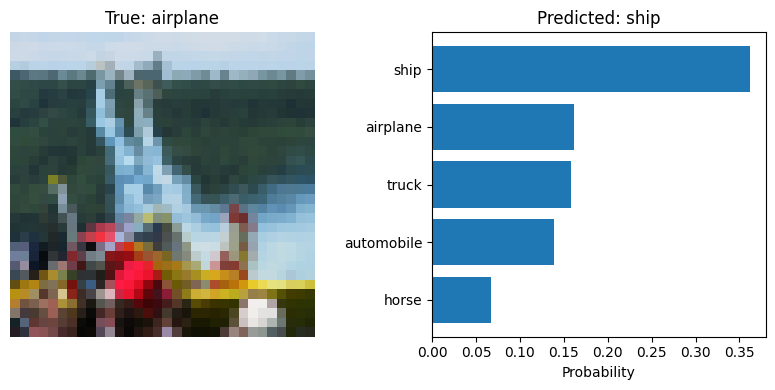

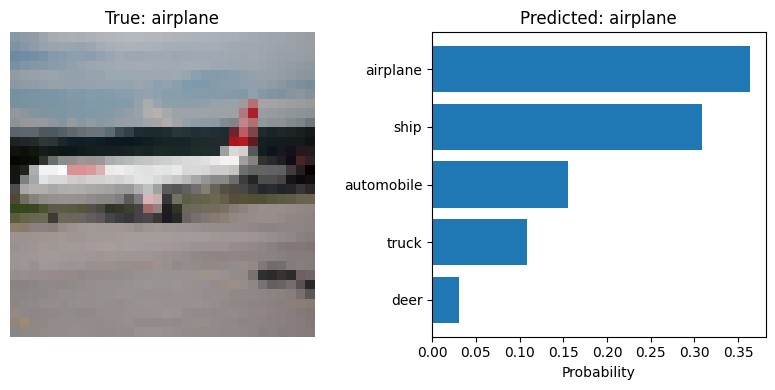

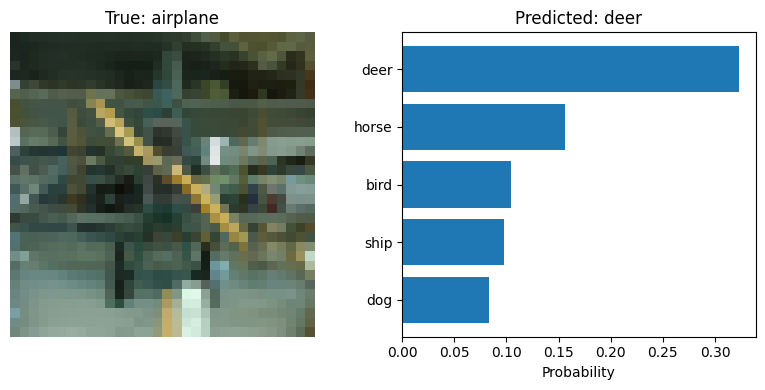

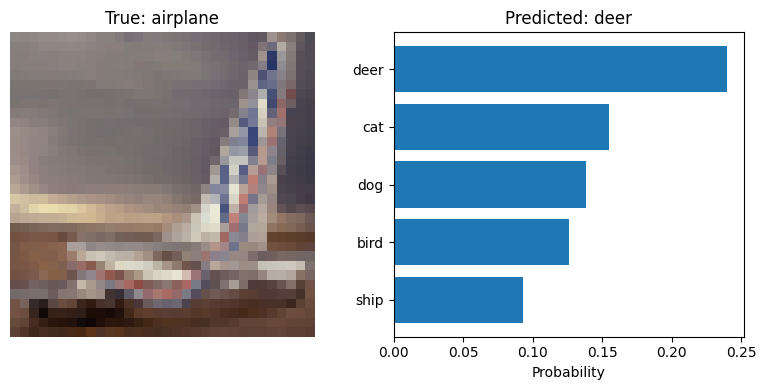

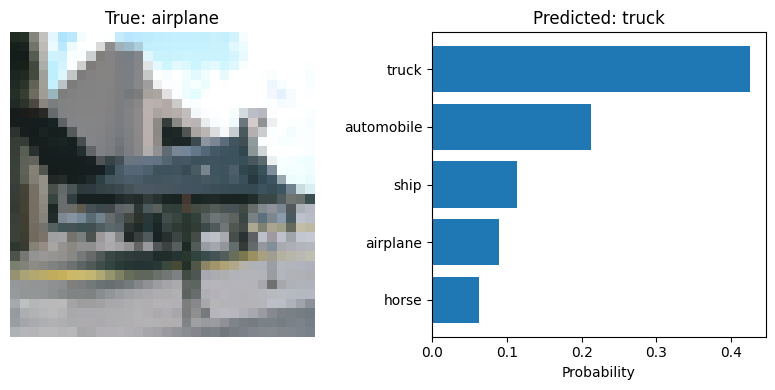

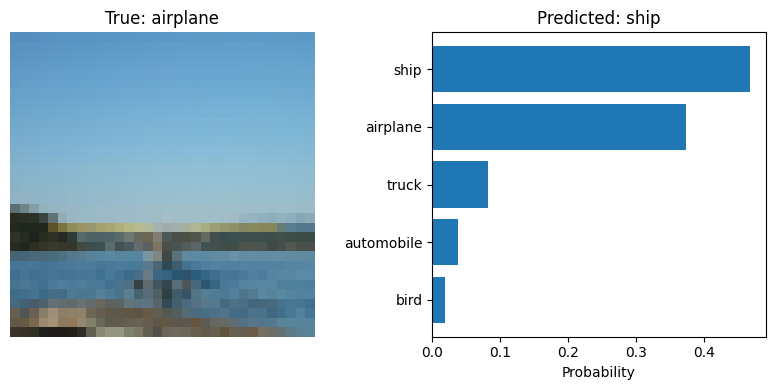

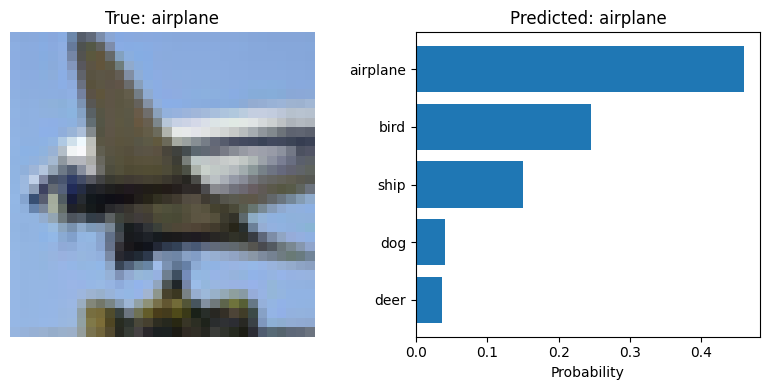

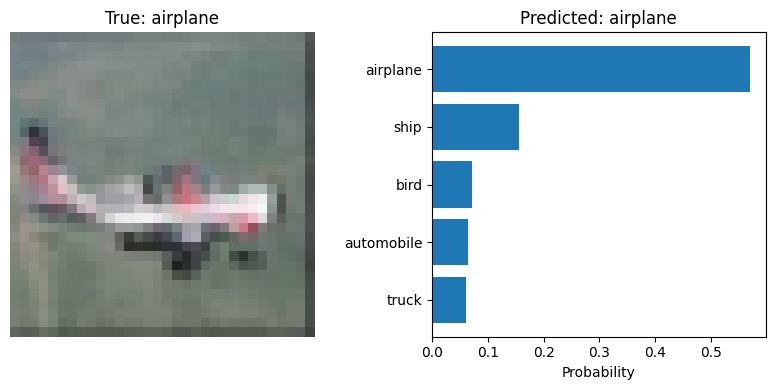

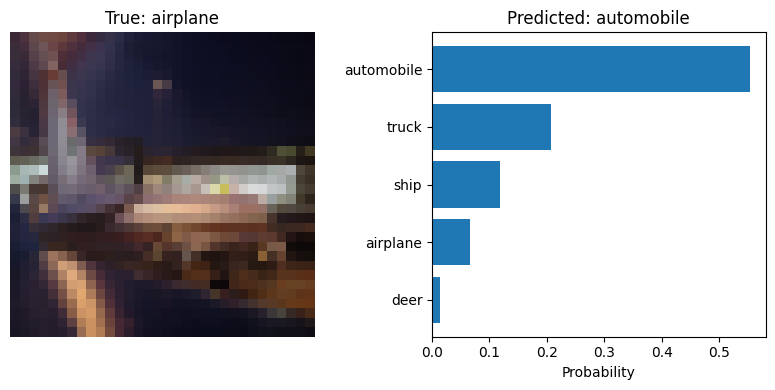

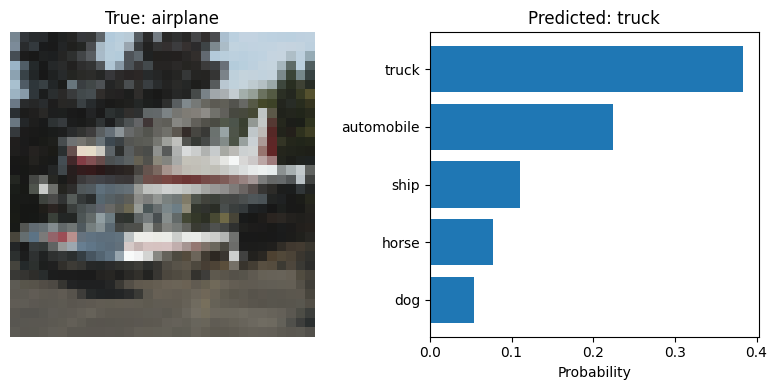

In [ ]:
# -------- Demo 3: Test the model on random images ---------------
print("Testing on sample images from test set...")
print('Accuracy of loaded model: ', checkpoint['test_accuracy'])
test_sample_images(demo_model, test_loader, class_names, num_samples=10)
